## Capstone 1 
# San Francisco Bay Water Quality

ref. [Water quality of SF Bay home page](https://sfbay.wr.usgs.gov/access/wqdata/index.html)
     

## Unit 10 - Capstone 1 - In-depth Analysis

"You’ve learned several techniques to use supervised and unsupervised learning to help build your predictive models... The techniques you’ll use in this project depend on your dataset."

"Regression analysis is a subfield of supervised machine learning. It aims to model the relationship between a certain number of features and a continuous target variable." [ref](https://towardsdatascience.com/supervised-learning-basics-of-linear-regression-1cbab48d0eba)

Several columns in the dataset were calculated based on a linear regression between two measurements. I thought it could be interesting to try to replicate these results.

/via Tara Schraga, USGS:

- You can not replicate our Calculated or Measured Light Extinction Coeff as we do not save the PAR data, or the pre-1988 Secci data. Note the difference between our Calculated and Measured parameters, I updated it for you  https://sfbay.wr.usgs.gov/access/wqdata/query/qhelp.html#excoef 
<p>
    
- your best bet for matching our calculated results is to conduct a linear regression with Discrete Oxygen v. Oxygen electrode output. Again, we occasionally dropped outliers (>2 x st dev) but it was less often.  You can only do this for any individual cruises up until August 2016, at that point we stopped collecting discrete oxygen samples because the sensors are so good at holding the calibration 
<p>
    
- you can try to replicate our regressions between discrete chl+fluorescence and discrete SPM+Optical Backscatter volts but you will usually not match perfectly. The regressions are a process, often there are regressions for each sub embayment (e.g. stn 36-22 = south bay, or south bay is split 36-25 and 24-22) - this is because of different phytoplankton populations, tide changing (flood/ebb), different sediments in the embayments, and more. Note, every regression we do for every parameter is cruise specific.



### Data :: Files
   * SFBayWaterQualityCombined.csv - all water quality parameters, original combined file
   * water_quality_units.json - units dictionary
   
**Data Format**

Water Quality - CSV format, one header row and 27 columns

<small>

```
Date, Time, Station Number, Distance from 36, Depth, Discrete Chlorophyll, Chlorophyll a/a+PHA, Fluorescence, Calculated Chlorophyll, Discrete Oxygen, Oxygen Electrode Output, Oxygen Saturation %, Calculated Oxygen, Discrete SPM, Optical Backscatter, Calculated SPM, Measured Extinction Coefficient, Calculated Extinction Coefficient, Salinity, Temperature, Sigma-t, Nitrite, Nitrate + Nitrite, Ammonium, Phosphate, Silicate, DateTime
```
</small>

For purposes of this investigation, the interesting columns are:

   * Discrete Oxygen - Concentration of dissolved oxygen in water samples measured in the laboratory
   * Oxygen Electrode Output [volts] - Voltage output of the oxygen electrode, a relative measure of the concentration of oxygen dissolved in the water.
   * Calculated Oxygen [mg/L] - Estimated concentration of dissolved oxygen, calculated from the oxygen electrode voltage output which is (calibrated) using linear regression with the discrete measures of the dissolved oxygen.
<p />

   * Discrete SPM [mg/L] - Concentration of suspended sediments (or suspended solids) in bay water at the corresponding station and depth, measured by weighing the mass of solids collected onto filters after drying.
   * Optical Backscatter [volts] - OBS Raw voltage-based output of the optical backscatter sensor, a relative measure of the concentration of suspended sediments or solids in the water.
   * Calculated SPM [mg/L] - The estimated concentration of suspended sediments, calculated from the OBS voltage output and linear regression (calibration) between the discrete measures of suspended solids and the OBS voltage.
<p />

   * Discrete Chlorophyll [mg/m3] - Concentration of chlorophyll content, measured by laboratory analysis of a water sample collected onto a filter.
   * Fluorescence [volts] - Raw voltage-based output of the fluorometer, a relative measure of the concentration of chlorophyll-a in the water.
   * Calculated Chlorophyll [mg/m3] - Estimated concentration of chlorophyll-a in water samples from in-vivo fluorescence measured with a ship-board fluorometer. The calculations are based on linear regressions of fluorescence and Discrete Chlorophyll.


## Setup

Import libraries

In [1]:
# Import useful libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression


In [3]:
# Read in the Water Quality data
wq_df = pd.read_csv('Data/orig/SFBayWaterQualityCombined.csv', 
                    header=0, 
                    parse_dates=['DateTime', 'Date'],
                    dtype={'Station' : str}
                    )


In [4]:
wq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237061 entries, 0 to 237060
Data columns (total 27 columns):
Date                                 237061 non-null datetime64[ns]
Time                                 237061 non-null int64
Station Number                       237061 non-null float64
Distance from 36                     236597 non-null float64
Depth                                237061 non-null float64
Discrete Chlorophyll                 15357 non-null float64
Chlorophyll a/a+PHA                  12895 non-null float64
Fluorescence                         220308 non-null float64
Calculated Chlorophyll               225275 non-null float64
Discrete Oxygen                      8245 non-null float64
Oxygen Electrode Output              189908 non-null float64
Oxygen Saturation %                  191606 non-null float64
Calculated Oxygen                    188107 non-null float64
Discrete SPM                         9778 non-null float64
Optical Backscatter                 

We don't need all of the columns for this investigation.

We'll also rename columns that currently have spaces in the names.

In [5]:
disc_calc_df = wq_df[['Date', 'Station Number',
                 'Discrete Oxygen', 'Oxygen Electrode Output',
                 'Calculated Oxygen',
                 'Discrete Chlorophyll', 'Fluorescence', 
                 'Calculated Chlorophyll',
                 'Discrete SPM', 'Optical Backscatter', 
                 'Calculated SPM'
                 ]].copy()

disc_calc_df.rename(columns = {
                 'Discrete Oxygen':'Discrete_Oxygen', 
                 'Oxygen Electrode Output':'Oxygen_Electrode_Output',
                 'Calculated Oxygen':'Calculated_Oxygen',
                 'Discrete Chlorophyll':'Discrete_Chlorophyll', 
                 'Calculated Chlorophyll':'Calculated_Chlorophyll',
                 'Discrete SPM':'Discrete_SPM', 
                 'Optical Backscatter':'Optical_Backscatter', 
                 'Calculated SPM':'Calculated_SPM'
                }, inplace = True)

<hr style="border: 3px solid green;">

**Confirm the correlation between measured and calculated values for Chlorophyll, Oxygen, and SPM.**

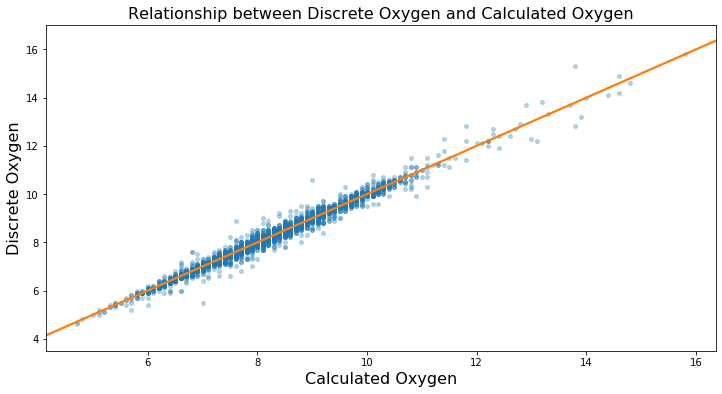

In [7]:
f = sns.regplot(x="Calculated_Oxygen", y="Discrete_Oxygen", 
                data=disc_calc_df, 
                fit_reg = True, marker=".",
                scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
                line_kws={'color': 'C1'}
               )
f.figure.set_size_inches(12, 6)
plt.ylabel("Discrete Oxygen", fontsize=16)
plt.xlabel("Calculated Oxygen", fontsize=16)
plt.title("Relationship between Discrete Oxygen and Calculated Oxygen", fontsize=16 )
plt.show()

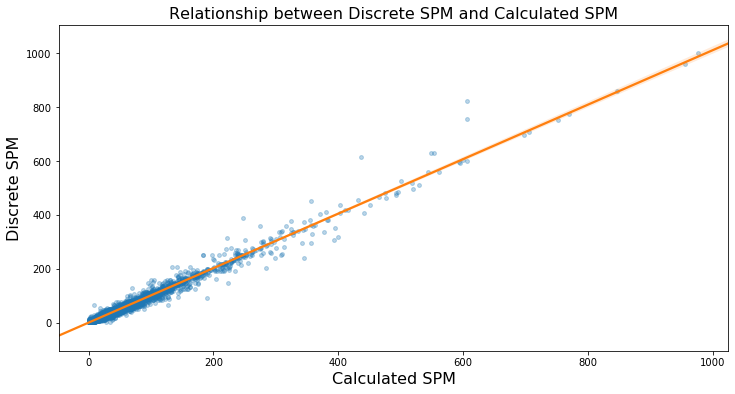

In [8]:
f = sns.regplot(x="Calculated_SPM", y="Discrete_SPM", 
                data=disc_calc_df, 
                fit_reg = True, marker=".",
                scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
                line_kws={'color': 'C1'}
               )
f.figure.set_size_inches(12, 6)
plt.ylabel("Discrete SPM", fontsize=16)
plt.xlabel("Calculated SPM", fontsize=16)
plt.title("Relationship between Discrete SPM and Calculated SPM", fontsize=16 )
plt.show()

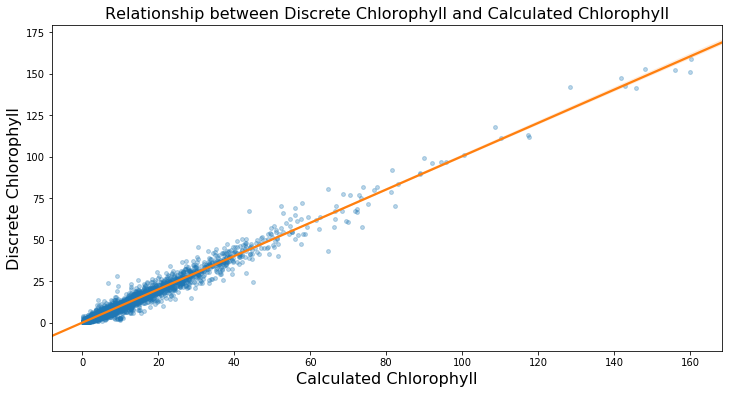

In [6]:
f = sns.regplot(x="Calculated_Chlorophyll", y="Discrete_Chlorophyll", 
                data=disc_calc_df, 
                fit_reg = True, marker=".",
                scatter_kws={'color': 'C0', 'alpha':0.3, 's':60}, 
                line_kws={'color': 'C1'}
               )
f.figure.set_size_inches(12, 6)
plt.ylabel("Discrete Chlorophyll", fontsize=16)
plt.xlabel("Calculated Chlorophyll", fontsize=16)
plt.title("Relationship between Discrete Chlorophyll and Calculated Chlorophyll", fontsize=16 )
plt.show()

The calculated values correlate nicely with the discrete (measured) values. 

Now, can we recapitulate the calculated values using linear regression?

**Group by date and pick a cruise where we have the most observations for the desired "discrete" value.**

In [9]:
# We'll be doing the regression for a single cruise.
# When choosing a cruise, I've decided to ignore cruises before 2000,
# so I'll reduce the set now for easier viewing and choosing.
df_2000s = disc_calc_df[(disc_calc_df.Date >= '2000-01-01')].copy()

### Oxygen

In [10]:
df_2000s.groupby(['Date']).count().sort_values('Discrete_Oxygen')

,Station Number,Discrete_Oxygen,Oxygen_Electrode_Output,Calculated_Oxygen,Discrete_Chlorophyll,Fluorescence,Calculated_Chlorophyll,Discrete_SPM,Optical_Backscatter,Calculated_SPM
Date,,,,,,,,,,
2019-06-04,479,0,479,479,32,475,475,25,479,479
2018-02-23,262,0,262,262,18,262,262,13,262,262
2018-02-07,516,0,516,516,35,118,516,28,516,516
2018-01-10,526,0,526,526,35,179,526,24,526,526
2017-12-06,529,0,529,529,35,321,529,20,529,529
...,...,...,...,...,...,...,...,...,...,...
2012-01-10,549,15,549,549,29,549,549,26,549,549
2015-10-15,540,15,526,526,35,141,540,28,540,540
2011-06-14,532,16,532,532,26,532,532,28,532,532


The cruise for 2011-06-14 looks promising. There were more Discrete Oxygen in two other cruises, but no Oxygen Electrode Output values were measured on those dates.

In [11]:
one_cruise_df = df_2000s[(df_2000s.Date >= '2011-06-14') & 
                         (df_2000s.Date <= '2011-06-15') & 
                         (df_2000s['Discrete_Oxygen'].notnull())
                        ]


In [12]:
one_cruise_df.head()


,Date,Station Number,Discrete_Oxygen,Oxygen_Electrode_Output,Calculated_Oxygen,Discrete_Chlorophyll,Fluorescence,Calculated_Chlorophyll,Discrete_SPM,Optical_Backscatter,Calculated_SPM
172413,2011-06-14,34.0,5.9,5.8,5.8,8.6,0.75,7.9,407.6,7.23,441.0
172420,2011-06-14,33.0,6.4,6.4,6.5,NaN,0.60,7.9,NaN,3.06,179.0
172436,2011-06-14,32.0,6.7,6.7,6.8,7.4,0.52,7.3,103.4,1.89,105.0
172456,2011-06-14,30.0,7.1,7.1,7.2,4.5,0.34,5.2,29.3,0.82,38.0
172505,2011-06-14,27.0,7.3,7.3,7.3,4.0,0.28,4.4,21.9,0.51,19.0


In [13]:
df_tmp = one_cruise_df[['Discrete_Oxygen', 
                        'Oxygen_Electrode_Output', 
                        'Calculated_Oxygen'
                       ]].copy()


In [14]:
# Regression
model = ols('Discrete_Oxygen ~ Oxygen_Electrode_Output', 
            data = df_tmp).fit()

df_tmp['Oxygen_prediction'] = round(model.predict(df_tmp),2)

In [15]:
df_tmp

,Discrete_Oxygen,Oxygen_Electrode_Output,Calculated_Oxygen,Oxygen_prediction
172413,5.9,5.8,5.8,5.87
172420,6.4,6.4,6.5,6.45
172436,6.7,6.7,6.8,6.74
172456,7.1,7.1,7.2,7.13
172505,7.3,7.3,7.3,7.32
172527,8.0,7.9,7.9,7.91
172587,7.5,7.5,7.5,7.52
172639,6.9,6.8,6.8,6.84
172654,7.0,7.0,7.0,7.03
172718,8.1,8.1,8.1,8.10


### SPM

In [16]:
df_2000s.groupby(['Date']).count().sort_values('Discrete_SPM')

,Station Number,Discrete_Oxygen,Oxygen_Electrode_Output,Calculated_Oxygen,Discrete_Chlorophyll,Fluorescence,Calculated_Chlorophyll,Discrete_SPM,Optical_Backscatter,Calculated_SPM
Date,,,,,,,,,,
2000-01-11,152,4,152,152,8,152,152,4,152,152
2017-05-17,75,0,75,75,11,75,75,4,75,75
2002-04-22,205,6,205,205,10,205,205,4,205,205
2001-04-16,212,6,212,212,9,212,212,4,212,212
2007-09-21,208,6,208,208,5,208,208,5,208,208
...,...,...,...,...,...,...,...,...,...,...
2018-10-17,526,0,526,526,35,526,526,29,516,516
2018-09-18,526,0,526,526,35,526,526,29,517,517
2018-12-05,527,0,527,527,34,527,527,29,527,527


The cruise for 2015-09-24 looks promising. ANother cruise had one more  Discrete SPM measurement, but far fewer Optical_Backscatter measurements.

In [17]:
one_cruise_df = df_2000s[(df_2000s.Date >= '2015-09-24') & 
                         (df_2000s.Date <= '2015-09-25')]

df_tmp2 = one_cruise_df[['Station Number',
                        'Discrete_SPM', 
                        'Optical_Backscatter', 
                        'Calculated_SPM'
                        ]].copy()
df_tmp2

,Station Number,Discrete_SPM,Optical_Backscatter,Calculated_SPM
207735,36.0,NaN,3.48,109.0
207736,36.0,147.8,5.10,156.0
207737,36.0,NaN,4.13,128.0
207738,36.0,43.8,1.09,39.0
207739,36.0,NaN,4.34,134.0
...,...,...,...,...
208277,657.0,NaN,0.64,19.0
208278,657.0,20.0,0.73,25.0
208279,657.0,NaN,0.68,22.0
208280,657.0,NaN,0.75,26.0


In [18]:
# Regression
model = ols('Discrete_SPM ~ Optical_Backscatter', 
            data = df_tmp2).fit()

df_tmp2['SPM_prediction'] = round(model.predict(df_tmp2),3)

df_tmp2

,Station Number,Discrete_SPM,Optical_Backscatter,Calculated_SPM,SPM_prediction
207735,36.0,NaN,3.48,109.0,110.961
207736,36.0,147.8,5.10,156.0,160.996
207737,36.0,NaN,4.13,128.0,131.037
207738,36.0,43.8,1.09,39.0,37.144
207739,36.0,NaN,4.34,134.0,137.523
...,...,...,...,...,...
208277,657.0,NaN,0.64,19.0,23.246
208278,657.0,20.0,0.73,25.0,26.026
208279,657.0,NaN,0.68,22.0,24.481
208280,657.0,NaN,0.75,26.0,26.643


That's not bad, but let's try again by groups of stations.

In [19]:
# 0: South Bay, 
# 1: Central Bay
# 2: Golden Gate, 
# 3: San Pablo Bay
# 4: Suisun Bay
# 5: Lower Sacramento River
# 6: Lower Sacramento River


st_group = {0: ['36', '35', '34', '33', '32', '31', '30', '29.5', 
                '29', '28.5', '28'],
            1: ['27', '26', '25', '24', '23', '22', '21'], 
            2: ['20', '19', '18', '17', '16', '15'], 
            3: ['14', '13', '12.5', '12', '11', '10'],
            4: ['9', '8', '405', '7', '411', '407','6', '5',
                '4', '3', '2'],
            5: ['649', '650', '651', '652', '653', '654'],
            6: ['655', '657', '659', '662']
           }


In [20]:
df_tmp2a = one_cruise_df[['Station Number',
                        'Discrete_SPM', 
                        'Optical_Backscatter', 
                        'Calculated_SPM'
                        ]]


In [21]:
# Extract DataFrames for each station group
i=0
st_groupdf = {}
while (i < len(st_group)):
    st_groupdf[i] = \
       df_tmp2a[df_tmp2a['Station Number'].isin(st_group[i])].copy()
    i += 1


In [22]:
for i in range(7):
    # Regression
    model = ols('Discrete_SPM ~ Optical_Backscatter', 
                data = st_groupdf[i]).fit()

    st_groupdf[i]['SPM_prediction'] = \
       round(model.predict(st_groupdf[i]),3)
    subset = st_groupdf[i].loc[:,'Calculated_SPM':'SPM_prediction']
    print("\nstation group", i, "\n", subset)


station group 0 
         Calculated_SPM  SPM_prediction
207735           109.0         107.223
207736           156.0         154.597
207737           128.0         126.231
207738            39.0          37.332
207739           134.0         132.372
...                ...             ...
207818            31.0          29.144
207819            23.0          21.541
207820            35.0          33.823
207821            29.0          27.097
207822            48.0          46.105

[88 rows x 2 columns]

station group 1 
         Calculated_SPM  SPM_prediction
207823            27.0          28.806
207824            43.0          53.302
207825            32.0          36.243
207826            23.0          23.120
207827            38.0          44.554
...                ...             ...
207916            13.0           8.247
207917            17.0          13.934
207918            14.0           8.685
207919            18.0          16.121
207920            13.0           7.372

[9

I can't say this is necessarily an improvement. If it mattered a lot, we could tweak the station groups some more.

### Chlorophyll

In [23]:
df_2000s.groupby(['Date']).count().sort_values('Discrete_Chlorophyll')

,Station Number,Discrete_Oxygen,Oxygen_Electrode_Output,Calculated_Oxygen,Discrete_Chlorophyll,Fluorescence,Calculated_Chlorophyll,Discrete_SPM,Optical_Backscatter,Calculated_SPM
Date,,,,,,,,,,
2007-03-28,208,6,208,208,0,208,0,12,208,208
2007-09-21,208,6,208,208,5,208,208,5,208,208
2007-07-23,173,7,173,173,6,173,173,7,173,173
2005-09-26,175,6,172,172,6,175,175,5,175,175
2006-09-29,184,6,184,184,6,184,184,6,184,184
...,...,...,...,...,...,...,...,...,...,...
2017-04-18,508,0,508,508,35,508,508,22,508,508
2012-02-07,296,26,0,0,35,74,102,31,74,102
2018-02-07,516,0,516,516,35,118,516,28,516,516


Both the 2015-09-24  cruise and the 2016-08-24 cruise have 36 Discrete Chlorophyll measurements. The 2016-08-24 cruise has more Fluorscence measurements, so I'll choose that one.

In [24]:
one_cruise_df = df_2000s[(df_2000s.Date >= '2016-08-24') & 
                         (df_2000s.Date <= '2016-08-25')]

df_tmp3 = one_cruise_df[['Station Number',
                         'Discrete_Chlorophyll', 
                         'Fluorescence', 
                         'Calculated_Chlorophyll'
                        ]].copy()
df_tmp3

,Station Number,Discrete_Chlorophyll,Fluorescence,Calculated_Chlorophyll
213931,36.0,3.6,0.43,3.8
213932,36.0,NaN,0.46,4.7
213933,36.0,NaN,0.43,3.9
213934,36.0,4.3,0.46,4.7
213935,36.0,NaN,0.43,3.8
...,...,...,...,...
214426,657.0,10.1,0.33,12.5
214427,657.0,12.0,0.30,11.5
214428,657.0,NaN,0.28,10.7
214429,657.0,NaN,0.30,11.2


In [25]:
# Regression
model = ols('Discrete_Chlorophyll ~ Fluorescence', 
            data = df_tmp3).fit()

df_tmp3['Chlorophyll_prediction'] = round(model.predict(df_tmp3),3)

df_tmp3

,Station Number,Discrete_Chlorophyll,Fluorescence,Calculated_Chlorophyll,Chlorophyll_prediction
213931,36.0,3.6,0.43,3.8,10.330
213932,36.0,NaN,0.46,4.7,11.573
213933,36.0,NaN,0.43,3.9,10.330
213934,36.0,4.3,0.46,4.7,11.573
213935,36.0,NaN,0.43,3.8,10.330
...,...,...,...,...,...
214426,657.0,10.1,0.33,12.5,6.187
214427,657.0,12.0,0.30,11.5,4.944
214428,657.0,NaN,0.28,10.7,4.115
214429,657.0,NaN,0.30,11.2,4.944


These predictions are way off from the calculated values.

Try again with station groups

In [26]:
df_tmp3a = one_cruise_df[['Station Number',
                         'Discrete_Chlorophyll', 
                         'Fluorescence', 
                         'Calculated_Chlorophyll'
                        ]].copy()


In [27]:
# Extract DataFrames for each station group
i=0
st_groupdf2 = {}
while (i < len(st_group)):
    st_groupdf2[i] = \
       df_tmp3a[df_tmp3a['Station Number'].isin(st_group[i])].copy()
    i += 1
    

In [28]:
for i in range(7):
    # Regression
    model = ols('Discrete_Chlorophyll ~ Fluorescence', 
                data = st_groupdf2[i]).fit()

    st_groupdf2[i]['Chlorophyll_prediction'] = \
       round(model.predict(st_groupdf2[i]),3)
    subset = st_groupdf2[i].loc[:,'Calculated_Chlorophyll':'Chlorophyll_prediction']
    print("\nstation group", i, "\n", subset)



station group 0 
         Calculated_Chlorophyll  Chlorophyll_prediction
213931                     3.8                   4.700
213932                     4.7                   4.767
213933                     3.9                   4.700
213934                     4.7                   4.767
213935                     3.8                   4.700
...                        ...                     ...
214015                     4.1                   4.432
214016                     4.1                   4.432
214017                     4.0                   4.410
214018                     4.0                   4.410
214019                     4.1                   4.432

[89 rows x 2 columns]

station group 1 
         Calculated_Chlorophyll  Chlorophyll_prediction
214020                     3.7                   3.718
214021                     3.9                   3.778
214022                     3.7                   3.718
214023                     3.8                   3.718
2140

Using station groups provides much better results for chlorophyll prediction. 